# Supervised Learning with a Parameterized Quantum Circuit 

In supervised learning the goal is to learn a function that maps given inputs to their corresponding outputs (i.e., their labels), based on example input-output pairs (i.e., the training data).


Within the course, you have seen the following diagram representing a typical Quantum Machine Learning situation with classical data:
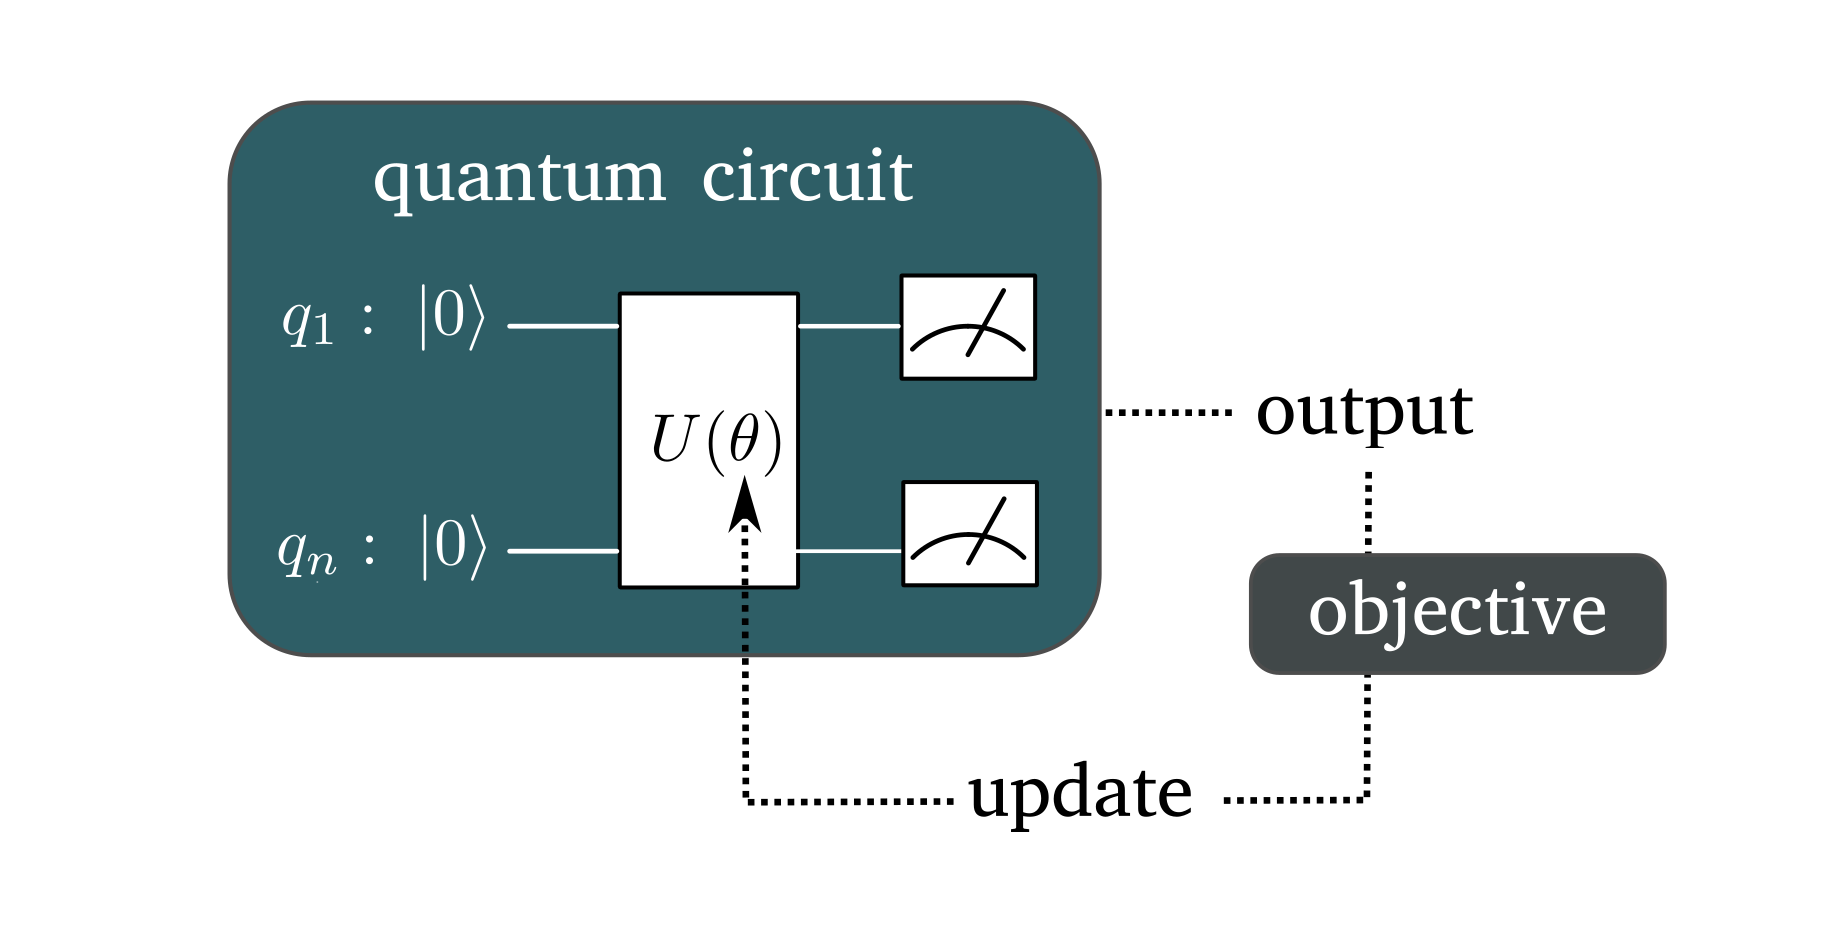


The quantum circuit in the above diagram is defined by two quantum circuits. First, we have a so-called ``encoding circuit`` that is used to encode the classical data into a quantum circuit. Secondly, we have a so-called ``variational circuit`` that dependends on real parameters which are tweaked by a classical optimizater in order to best classify the training examples. 

In this notebook we implement the above diagram to learn a toy-dataset, explaining each step along the way.

The aim for this version of the notebook is to try the dual problem for classification. This is the method proposed in https://arxiv.org/abs/1804.11326

The authors of the paper use a more complicated feature map than the one used here, which is just a tensor-product circuit.

In [1]:
# !pip install cirq
from scipy.optimize import minimize

import cirq
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

%matplotlib inline

## I. Generating the data

We generate a random 2D binary classification dataset consisting of points in a square, which +1 labels if they lie within a circle.

In [2]:
# Set a random seed
np.random.seed(42)

# Make a dataset of points inside and outside of a circle
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/-1 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float): radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = -1
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals), np.array(yvals)

# Plot the above dataset
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array): array of data points 
        y (array[int]): array of data points labels
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == -1
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

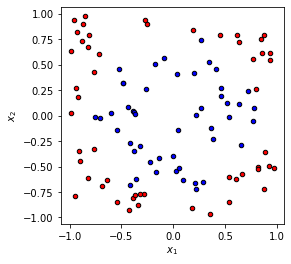

In [3]:
X, Y = circle(100)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(X, Y, fig=fig, ax=ax)
plt.show()

## III. Split into train/validation

In Machine Learning, the goal is to build a model that generalizes well -- i.e., performance should also be good on unseen data. 

One way to benchmark this is to split the data into a training set and a validation set.

In [4]:
data_train, data_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42, stratify=Y)

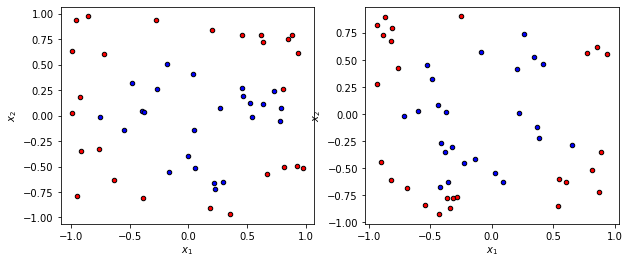

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_data(data_train, Y_train, fig=fig, ax=ax[0])
plot_data(data_test, Y_test, fig=fig, ax=ax[1])
plt.show()

In [6]:
Y_train.size

50

## IV. Constructing the quantum circuit model

### 1. Setting a few hyperparameters 

We use 2 qubits (i.e., one qubit per dimension). 

In [21]:
# Circuit hyperparameters
n_qubits = 2

# Create a register of qubits
qubits = cirq.LineQubit.range(n_qubits)   

# Initialize simulator
simulator = cirq.Simulator()

# initial parameters 
n_params = data_train.shape[0]

# np.random.seed(42)
alpha0 = np.random.rand(n_params)

print("Number of parameters to optimize: ",n_params)
print(alpha0)

Number of parameters to optimize:  50
[0.55840425 0.42422201 0.90635439 0.11119748 0.4926251  0.01135364
 0.46866064 0.05630328 0.11881792 0.11752625 0.6492103  0.74604488
 0.58336877 0.96217255 0.37487058 0.28571209 0.86859913 0.22359584
 0.96322254 0.01215447 0.96987883 0.04315991 0.89114311 0.52770111
 0.9929648  0.07379656 0.55385428 0.96930254 0.52309784 0.62939864
 0.69574869 0.45454106 0.62755808 0.58431431 0.90115801 0.04544638
 0.28096319 0.95041148 0.89026378 0.45565675 0.6201326  0.27738118
 0.18812116 0.4636984  0.35335223 0.58365611 0.07773464 0.97439481
 0.98621074 0.69816171]


### 2. Create the function yielding the circuit

We will set the feature map to be a layer of RZ-RY-RZ operations, and input the data as the angles.

Note that the hermitian conjugate of the RZ-RY-RZ feature map is still RZ-RY-RZ, but with opposite angles.


In [22]:
# Encoding layer that uses x_i as angles to encode data.
def kernel_estimator(x):
    # - Apply U_Phi(x_j).
    yield [cirq.rz(x[k])(q) for k, q in enumerate(qubits)]
    yield [cirq.ry(x[k])(q) for k, q in enumerate(qubits)]
    yield [cirq.rz(x[k])(q) for k, q in enumerate(qubits)]
    

def kernel_estimator_circuit(x_i, x_j):
    return cirq.Circuit(kernel_estimator(x_j), kernel_estimator(-x_i))
        
test_circuit = kernel_estimator_circuit(X[0,:], X[1,:])
print("Data i: ")
print(X[0,:])
print("Data j: ")
print(X[1,:])
print("Data i divided by pi: ", X[0,:] / np.pi,"\n")
print("Data j divided by pi: ", X[1,:] / np.pi,"\n")

print(test_circuit.to_text_diagram(transpose=True))

Data i: 
[-0.25091976  0.90142861]
Data j: 
[0.46398788 0.19731697]
Data i divided by pi:  [-0.07987024  0.28693364] 

Data j divided by pi:  [0.14769193 0.06280794] 

0          1
│          │
Rz(0.148π) Rz(0.063π)
│          │
Ry(0.148π) Ry(0.063π)
│          │
Rz(0.148π) Rz(0.063π)
│          │
Rz(0.08π)  Rz(-0.287π)
│          │
Ry(0.08π)  Ry(-0.287π)
│          │
Rz(0.08π)  Rz(-0.287π)
│          │


### 3. Measure the circuit to estimate the Kernel

The Kernel can be measured in many ways, but an easy way to go is to simply measure the probability (relative frequency, if finite sampling is used) of having all zeros.

In [23]:
# Determine the relevant output of the circuit
def run_circuit(x_i, x_j):
    circuit = kernel_estimator_circuit(x_i, x_j)
    result = simulator.simulate(circuit)
    all_zeros = result.final_state_vector[0]
    return abs(all_zeros)

run_circuit(X[0,:], X[1,:])

0.876882

### 3.5 Computing the Kernel
Since the Kernel only depends on the datapoints `X`, it can be computed once and for all before the optimization. The Kernel does not depend on the parameters `alpha`.

In [24]:
Kern = np.empty([n_params, n_params])
for i in range(n_params):
    for j in range(n_params):
        Kern[i, j] = run_circuit(data_train[i], data_train[j])

### 4. Set the loss function to optimize

The cost function will be the Lagrangian of the dual problem. This must take as input the parameters, the data and the labels. Also, a function for the equality constraints must be defined. The inequality constraints can be expressed by a `Bound` object (from `scipy.optimize`)

In [25]:
# Compute the cost
def compute_cost(params, X, Y):
    cost = sum(params)
    for i in range(n_params):
        for j in range(n_params):
            # K_ij = run_circuit(X[i], X[j])
            cost -= 1 / 2 * Y[i] * Y[j] * params[i] * params[j] * Kern[i, j]
    return cost

# Compute the equality constraint
def compute_equality_constraint(params, Y):
    return np.dot(params, Y)

# Save the current cost, and constraint to plot later
tracking_cost = []
tracking_constraint = []

# Loss function to pass to classical optimizer. We return the negative cost value because we will want to maximize the cost function
def cost_to_optimize(params):
    cost = -compute_cost(params, data_train, Y_train)
    tracking_cost.append(cost)
    print("cost = ", cost)
    return cost

# Constraint function to pass to classical optimizer
def constraint_to_optimize(params):
    constr = compute_equality_constraint(params, Y_train)
    tracking_constraint.append(constr)
    print("constr = ", constr)
    return constr


### 5. Definition of the optimization hyperparameters

Lastly, before optimizing, we still need to define some of the hyperparameters for `scipy.optimize.minimize`.

In [26]:
from scipy.optimize import Bounds

In [27]:
# upper-bound constant for the parameters
# C = 1.

eq_constr = {'type': 'eq',
             'fun' : constraint_to_optimize
}
bounds = Bounds(0., np.inf)
method = 'SLSQP'
tol = 1e-6
options = {
    'maxiter': 100,
    'disp': True
}

## IV. Optimize

Now is the time to optimize the parameters of the model for classification. We will use a simple derivative-free optimizer called SLSQP.

We must remember that for the dual problem we want to maximize the Lagrangian, i.e. minimize the opposite of it.

In [ ]:
from time import time
start_time = time()
final_params = minimize(cost_to_optimize,
x0=alpha0,
method=method,
bounds=bounds,
constraints=eq_constr,
options=options
)
end_time = time()
print(end_time-start_time)

In [ ]:
print(tracking_cost)

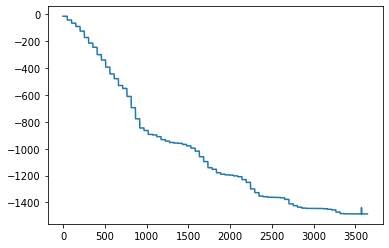

In [29]:
plt.plot(range(len(tracking_cost)), tracking_cost)

In [ ]:
final_params

### 1. Computing the bias
To use the SVM as a classifier, we still need to define a bias $b$.  We can do this as remarked in https://arxiv.org/abs/1804.11326.

Let's first store the coefficients $\alpha_{opt}$ obtained from the optimization. Then we can choose the first one that it is not zero, take the corresponding $y_i$ and find $b$

In [43]:
alpha_opt = final_params.x

for idx, alpha in enumerate(alpha_opt):
    if not np.isclose(alpha, 0.):
        idx_first_nnz = idx
        break

b = Y_train[idx_first_nnz] / np.dot(Y_train, np.multiply(alpha_opt, Kern[:, idx_first_nnz]))

print(b)

-0.14957147717242558


## V. Performances

Let us see the performance of our model! 

To do so, we define the ``predict`` function, which converts the output probabilities of the circuit to the binary labels of our dataset.

In [48]:
def predict(params_opt, x):
    func_margin = 0.
    for i in range(n_params):
        func_margin += Y_train[i] * params_opt[i] * run_circuit(data_train[i], x)
    return (func_margin + b) / np.abs(func_margin + b)

predict(alpha_opt, (-0.5, -1.))


-1.0

In [50]:
def predict_dataset(params_opt, X):
    return np.array([predict(params_opt, x_test) for x_test in X])

In [51]:
# before training
print("Accuracy on training set: ", accuracy_score(Y_train,predict_dataset(alpha0,data_train)))
print("Accuracy on validation set: ", accuracy_score(Y_test,predict_dataset(alpha0,data_test)))

Accuracy on training set:  0.52
Accuracy on validation set:  0.52


In [52]:
# after training
print("Accuracy on training set: ", accuracy_score(Y_train,predict_dataset(alpha_opt,data_train)))
print("Accuracy on validation set: ", accuracy_score(Y_test,predict_dataset(alpha_opt,data_test)))

Accuracy on training set:  0.62
Accuracy on validation set:  0.64


Let us visualize the results now!

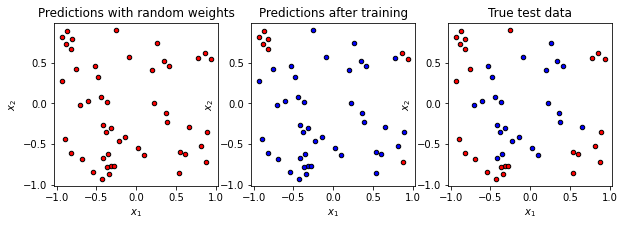

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(data_test, predict_dataset(alpha0, data_test), fig, axes[0])
plot_data(data_test, predict_dataset(alpha_opt, data_test), fig, axes[1])
plot_data(data_test, Y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.show()

Conclusion for the dual problam: with 50 samples there is only a slightly better increase after training has been done.